In [40]:
import os
import pandas as pd #Import pandas for operations
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix, ConfusionMatrixDisplay


In [41]:
#0. Import data
dataframe = pd.read_csv('data/sdss_100k_galaxy_form_burst.csv', low_memory=False, header=1)
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [42]:
# 0.1. Data Statistical Analysis
print(f"Dataset shape: {dataframe.shape}")

numerical_features = dataframe.select_dtypes(include='number').columns
z_scores = dataframe[numerical_features].apply(zscore)  # compute z-score for each numeric column
threshold = 3 #How many STD. we consider outlier.
outliers_z = (abs(z_scores) > threshold)

print(dataframe[outliers_z.any(axis=1)])  # rows containing at least one outlier
# Data is somewhat skewed


Dataset shape: (100000, 43)
                     objid            specobjid          ra        dec  \
4      1237648702973149350   332154249716721664  198.706864  -1.046217   
42     1237648721763238209   314301479399745536  170.073523   0.405995   
54     1237651192432165212  8192142948407990272  131.241240  53.208364   
58     1237651251482067624  7181230230211942400  122.631878  45.281591   
72     1237648704061309661  4517153671457560576  231.533375  -0.340179   
...                    ...                  ...         ...        ...   
99928  1237662236392685639  1384880019989358592  184.933948   9.148592   
99936  1237662236929622034  1384887441692846080  185.110612   9.424278   
99957  1237654381978845196   623782117049919488  140.589226  53.606884   
99968  1237664667902214147  2354413718323881984  165.917906  37.929384   
99977  1237664669494804798  1783437871319902208  121.816368  21.689839   

                u           g         r         i         z  modelFlux_u  ...  \
4 

In [43]:
# 1 Data pre-processing

# 1.1.0 Smoothen out outliers by means of Robust Scaler
robust_scaler = RobustScaler() # Initialize scaler
robust_scaled_values = robust_scaler.fit_transform(dataframe[numerical_features]) # Scale only numerical data from dataset.
robust_scaled_df = pd.DataFrame(robust_scaled_values, columns=numerical_features, index=dataframe.index) # Convert scaled data to pandas dataframe NB: index so it aligns with OG.
scaled_dataframe = dataframe.copy() # Create a copy of Dataframe to preserve original.
scaled_dataframe[numerical_features] = robust_scaled_df # Copy scaled values over into new copy.

# 1.1.1 remove unnecessary columns
modified_dataframe = scaled_dataframe.drop(['objid', 'specobjid', 'class'], axis=1)

In [44]:
# 3. Begin Training Model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#3.1. Setup Model with Params.
class galaxy_classification_nn(nn.Module):
    def __init__(self,  dropout_rate=0.4):

        # Store dropout rate.
        self.dropout_rate = dropout_rate

        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=39, out_features=133)
        self.hidden_layer2 = nn.Linear(in_features=133, out_features=133)
        self.output_layer = nn.Linear(in_features=133, out_features=2)

        # Specify activation functions.
        self.activation_function1 = nn.Tanh() # Input -> Hidden 1
        self.activation_function2 = nn.ReLU() # Hidden 1 -> Hidden 2

        # Added dropout layers.
        self.dropout_layer1 = nn.Dropout(p=self.dropout_rate) #Dropout H1 -> H2
        self.dropout_layer2 = nn.Dropout(p=self.dropout_rate) #Droput H2 -> Output


    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.activation_function1(x)
        x = self.dropout_layer1(x)

        x = self.hidden_layer2(x)
        x = self.activation_function2(x)
        x = self.dropout_layer2(x)

        x = self.output_layer(x)

        return x

    def get_weights(self, model_type):
        if model_type == 'traditional':
            init.xavier_normal_(self.input_layer.weight, )
            init.kaiming_normal(self.hidden_layer.weight)
            init.xavier_normal_(self.output_layer.weight)
            return
        elif model_type == 'sign_based':
            init.xavier_normal_(self.input_layer.weight)

In [45]:
def standardize_data(data, std_type):
    scaler = StandardScaler()
    data_scaled = None

    if std_type == 'fit':
        data_scaled = scaler.fit_transform(data)
    else:
        data_scaled = scaler.transform(data)

    return data_scaled

In [46]:
import torch.optim as optim

#3.2. Init. model
device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.4).to(device)

#3.2. Setup Optimizer
loss_function = nn.CrossEntropyLoss()

# Sign-Based approach setup
error_optimizer = optim.Rprop(
    galaxy_classification_model.parameters(),
    lr=0.01,        # initial step size per weight
    etas=(0.5, 1.2),# (eta_minus, eta_plus)
    step_sizes=(1e-6, 50.0)  # (min_step, max_step)
)

#SGD Regular setup - Control
control_error_optimizer = optim.SGD(galaxy_classification_model.parameters(), lr=0.01, momentum=0.9)

Learning rate: 0.001, Dropout rate: 0.2

Current Fold 1:

Current Fold 2:

Current Fold 3:

Current Fold 4:

Current Fold 5:

Current Fold 6:

Current Fold 7:

Current Fold 8:

Current Fold 9:

Current Fold 10:
Avg F1 for lr=0.001, dropout=0.2: 0.768
Learning rate: 0.001, Dropout rate: 0.4

Current Fold 1:

Current Fold 2:

Current Fold 3:

Current Fold 4:

Current Fold 5:

Current Fold 6:

Current Fold 7:

Current Fold 8:

Current Fold 9:

Current Fold 10:
Avg F1 for lr=0.001, dropout=0.4: 0.735
Learning rate: 0.001, Dropout rate: 0.6

Current Fold 1:

Current Fold 2:

Current Fold 3:

Current Fold 4:

Current Fold 5:

Current Fold 6:

Current Fold 7:

Current Fold 8:

Current Fold 9:

Current Fold 10:
Avg F1 for lr=0.001, dropout=0.6: 0.597
Learning rate: 0.01, Dropout rate: 0.2

Current Fold 1:

Current Fold 2:

Current Fold 3:

Current Fold 4:

Current Fold 5:

Current Fold 6:

Current Fold 7:

Current Fold 8:

Current Fold 9:

Current Fold 10:
Avg F1 for lr=0.01, dropout=0.2: 0.75

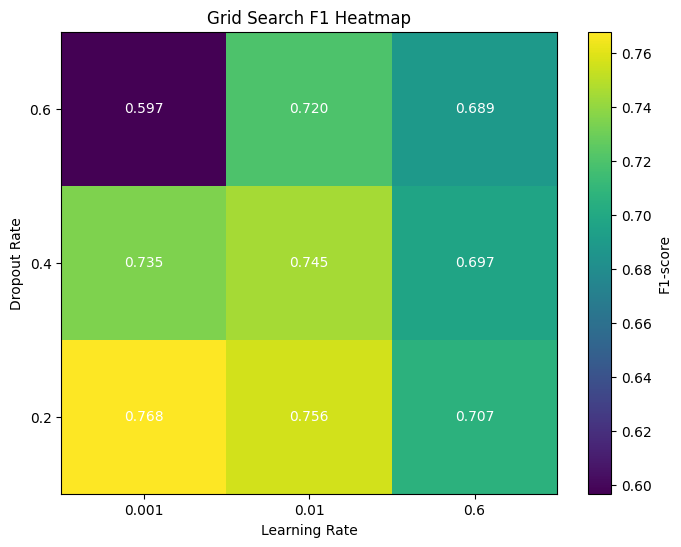

In [52]:
# Hyperparameter optimization: TODO: Move Below
# Variables: Initial learning rate and dropout rate
k_fold = StratifiedKFold(n_splits=10, shuffle=True)
learning_rates_list = [0.001, 0.01, 0.05, 0.1]
dropout_rates_list = [0.2, 0.4, 0.6, 0.8]

results_list = []
hpo_epoch_count = 10

# 1. Get Dataset Labels & Features TODO: Remove when move down.

dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

for learning_rate in learning_rates_list:
    for dropout_rate in dropout_rates_list:
        print(f"Learning rate: {learning_rate}, Dropout rate: {dropout_rate}")
        fold_scores = []

        for fold, (train_index, test_index) in enumerate(k_fold.split(dataset_features, dataset_labels), 1):
            print(f"\nCurrent Fold {fold}:")

            # 2. Split current folds into test and training set
            features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
            labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

            features_train_numpy = features_train.to_numpy()
            features_test_numpy = features_test.to_numpy()

            # 3. Normalize dataset
            standard_scaler = StandardScaler()
            features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
            features_test_scaled = standard_scaler.transform(features_test_numpy)

            # 4. Convert to Tensors
            features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
            features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
            labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
            labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

            # 5. Create Dataloaders
            training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
            testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

            training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
            testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

            # 6. Compute class weights to address class imbalance
            class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
            class_weights = torch.tensor(class_weights, dtype=torch.float32)


            #Setup current model.
            galaxy_classification_model_hpo = galaxy_classification_nn(dropout_rate=dropout_rate).to(device)
            loss_function_hpo = nn.CrossEntropyLoss()
            error_optimizer_hpo = optim.Rprop(
                galaxy_classification_model_hpo.parameters(),
                lr=learning_rate,  # initial step size per weight
                etas=(0.5, 1.2),# (eta_minus, eta_plus)
                step_sizes=(1e-6, 50.0)  # (min_step, max_step)
            )

            # train for N epochs
            for epoch in range(hpo_epoch_count):
                galaxy_classification_model_hpo.train()
                for feature_batch, label_batch in training_dataset_loader:
                    error_optimizer_hpo.zero_grad()
                    outputs_hpo = galaxy_classification_model_hpo(feature_batch)
                    loss_hpo = loss_function_hpo(outputs_hpo, label_batch)
                    loss_hpo.backward()
                    error_optimizer_hpo.step()

            # evaluate
            galaxy_classification_model_hpo.eval()
            preds_hpo, true_hpo = [], []
            with torch.no_grad():
                for feature_batch, label_batch in testing_dataset_loader:
                    outputs_eval_hpo = galaxy_classification_model_hpo(feature_batch)
                    preds_hpo.extend(torch.argmax(outputs_eval_hpo, dim=1).cpu().numpy())
                    true_hpo.extend(label_batch.cpu().numpy())

            f1 = f1_score(true_hpo, preds_hpo, average="macro")
            fold_scores.append(f1)

        avg_f1 = np.mean(fold_scores)
        print(f"Avg F1 for lr={learning_rate}, dropout={dropout_rate}: {avg_f1:.3f}")
        results_list.append({"learning_rate": learning_rate, "dropout": dropout_rate, "f1": avg_f1})

# 2. Convert results to dataframe for visualization.
results_df = pd.DataFrame(results_list)
pivot_table = results_df.pivot(index="dropout", columns="learning_rate", values="f1")
print(pivot_table)

# 3. Plot Heatmap.
plt.figure(figsize=(8,6))
heatmap = plt.imshow(pivot_table, cmap="viridis", aspect="auto", origin="lower")

plt.colorbar(heatmap, label="F1-score")
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

plt.xlabel("Learning Rate")
plt.ylabel("Dropout Rate")
plt.title("Grid Search F1 Heatmap")

for i in range(pivot_table.shape[0]):  # rows (dropout)
    for j in range(pivot_table.shape[1]):  # cols (learning rate)
        plt.text(j, i, f"{pivot_table.iloc[i, j]:.3f}", ha="center", va="center", color="white")

plt.show()


In [ ]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True)

accuracy_score_list = []
f1_score_list = []
epoch_count = 10

save_dir = "saved_classifiers"
os.makedirs(save_dir, exist_ok=True)

current_best_performing_model = 0.0

# 1. Get Dataset Labels & Features
dataset_features = modified_dataframe.select_dtypes(include=[np.number])
dataset_labels = modified_dataframe['subclass'].map({'STARBURST': 1, 'STARFORMING': 0})

print("\nStarting model training:\n")

for fold, (train_index, test_index) in enumerate(k_fold.split(dataset_features, dataset_labels), 1):
    print(f"\nCurrent Fold {fold}:")

    # 2. Split current folds into test and training set
    features_train, features_test = dataset_features.copy().iloc[train_index], dataset_features.copy().iloc[test_index]
    labels_train, labels_test =dataset_labels.copy().iloc[train_index], dataset_labels.copy().iloc[test_index]

    features_train_numpy = features_train.to_numpy()
    features_test_numpy = features_test.to_numpy()

    # 3. Normalize dataset
    standard_scaler = StandardScaler()
    features_train_scaled = standard_scaler.fit_transform(features_train_numpy)
    features_test_scaled = standard_scaler.transform(features_test_numpy)

    # 4. Convert to Tensors
    features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
    features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
    labels_train_tensor = torch.tensor(labels_train.to_numpy(), dtype=torch.long)
    labels_test_tensor = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # 5. Create Dataloaders
    training_dataset_converted = TensorDataset(features_train_tensor, labels_train_tensor)
    testing_dataset_converted = TensorDataset(features_test_tensor, labels_test_tensor)

    training_dataset_loader = DataLoader(training_dataset_converted, batch_size=64, shuffle=True)
    testing_dataset_loader = DataLoader(testing_dataset_converted, batch_size=64, shuffle=True)

    # 6. Compute class weights to address class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train), y=labels_train.to_numpy())
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # 7. Redefine model in training loop.
    galaxy_classification_model = galaxy_classification_nn(dropout_rate=0.4).to(device)
    loss_function = nn.CrossEntropyLoss()
    error_optimizer = optim.Rprop(
        galaxy_classification_model.parameters(),
        lr=0.01,        # initial step size per weight
        etas=(0.5, 1.2),# (eta_minus, eta_plus)
        step_sizes=(1e-6, 50.0)  # (min_step, max_step)
    )

    # 8. Begin training loop for fold
    galaxy_classification_model.train()
    for epoch in range(epoch_count):
        for features, labels in training_dataset_loader:
            error_optimizer.zero_grad()
            outputs = galaxy_classification_model(features)
            loss = loss_function(outputs, labels)
            loss.backward()
            error_optimizer.step()

    # 9. Evaluation loop
    galaxy_classification_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for features, labels in testing_dataset_loader:
            outputs = galaxy_classification_model(features)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())


    # Compute metrics

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    accuracy_score_list.append(acc)
    f1_score_list.append(f1)

    # Per-class precision and recall
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class    = recall_score(all_labels, all_preds, average=None)

    print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")
    for cls_idx, (prec, rec) in enumerate(zip(precision_per_class, recall_per_class)):
        print(f"  Class {cls_idx} -> Precision: {prec:.3f}, Recall: {rec:.3f}")

    print(f"Fold {fold} Accuracy: {acc:.3f}, F1: {f1:.3f}")

    # Evaluate if current model is best and save
    if f1 > current_best_performing_model:
        current_best_performing_model = f1
        file_save_path = os.path.join(save_dir, f"f1_score_{fold}.pt")
        torch.save(galaxy_classification_model.state_dict(), file_save_path)
        print(f"Save current best performing model to {file_save_path} with accuracy {f1:.3f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

# Average results across folds
print("\n=== Final Results ===")
print("Average Accuracy:", np.mean(accuracy_score_list))
print("Average F1-score:", np.mean(f1_score_list))